#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [ ]:
#Загрузка библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor

In [ ]:
#Загрузка данных
try:
    data = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])
except:
    try:
        data  = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
    except:
        print('Ошибка. Проверьте путь к файлу')
data.sort_index(inplace=True)        
data.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


В датасете 26 496 строк.

(4416, 1)

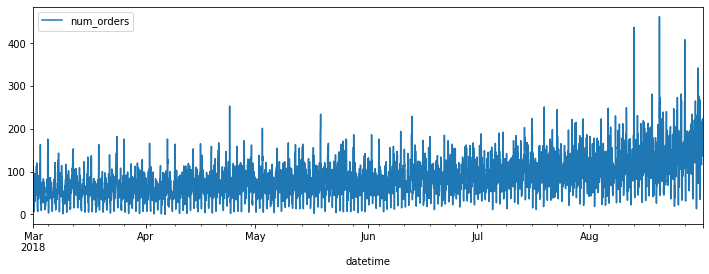

In [ ]:
#Ресемплинг по одному часу
data = data.resample('1H').sum()
data.plot(figsize=(12,4))
data.shape

После ресемплинга количество строк 4 416.

## Анализ

In [ ]:
data.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


<AxesSubplot:xlabel='datetime'>

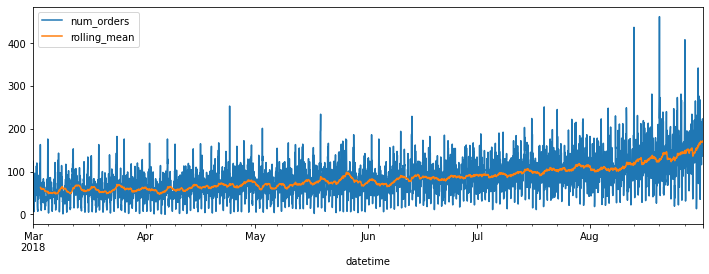

In [ ]:
data['rolling_mean'] = data.rolling(50).mean()
data.plot(figsize=(12,4))

<AxesSubplot:xlabel='datetime'>

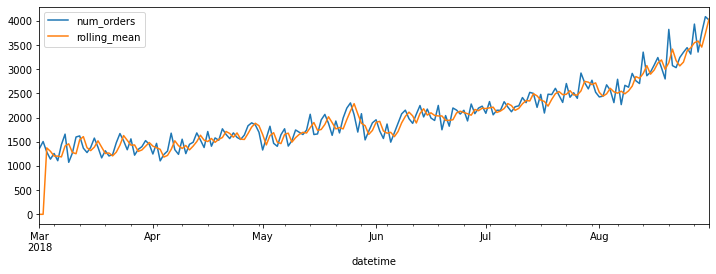

In [ ]:
data.resample('1D').sum().plot(figsize=(12,4))

In [ ]:
#Функция построения графиков тренда, сезонности и остатков
def decompose(data):
    decomposed = seasonal_decompose(data)
    plt.figure(figsize=(12, 20))

    plt.subplot(311)
    decomposed.trend.plot(ax=plt.gca())
    plt.title('Trend')

    plt.subplot(312)
    decomposed.seasonal.plot(ax=plt.gca())
    plt.title('Seasonality')

    plt.subplot(313)
    decomposed.resid.plot(ax=plt.gca())
    plt.title('Residuals')
    plt.tight_layout()

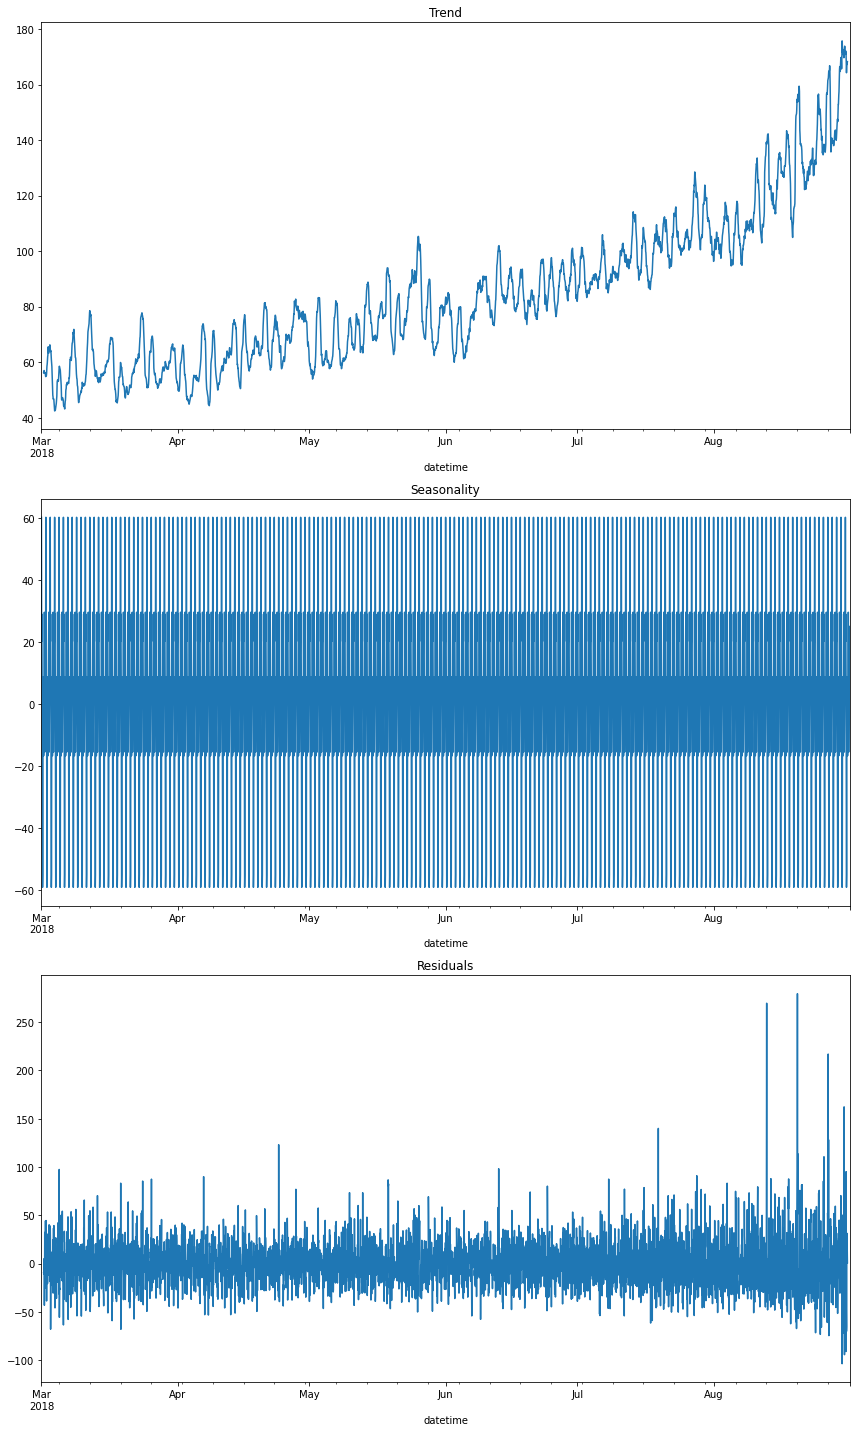

In [ ]:
decompose(data['num_orders'])

Для наглядности необходимо взять меньший интервал, например недельный.

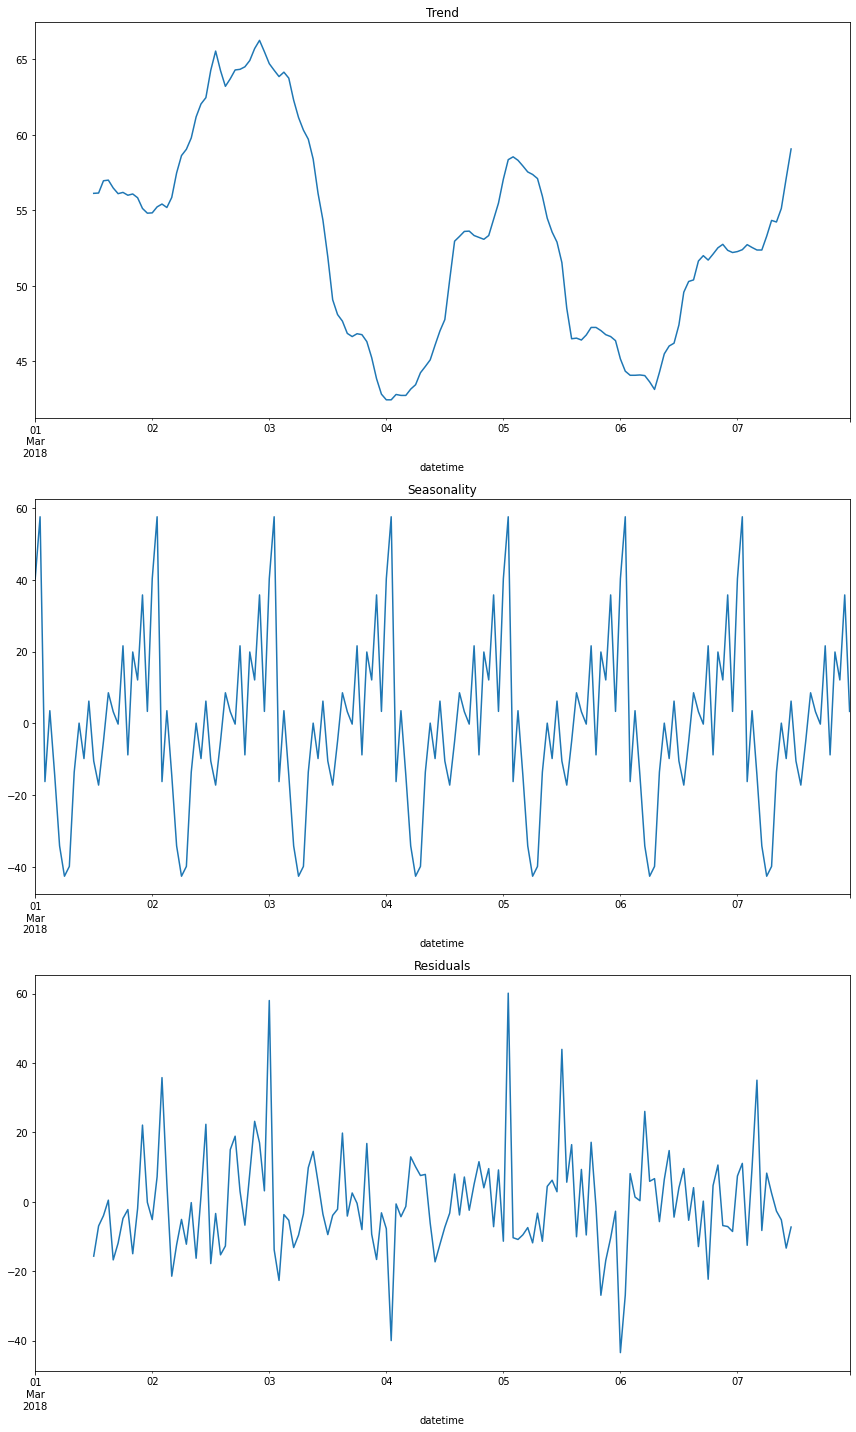

In [ ]:
decompose(data['num_orders']['2018-03-01':'2018-03-07'])

Заметны суточные изменения количество заказов: увеличение заказов к концу дня, резкое уменьшение после полуночи. 

In [ ]:
#Функция создания признаков
def make_features(data, max_lag, rolling_mean_size):
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()


In [ ]:
make_features(data, 24, 7)
data = data.dropna()
data.head(10)

,num_orders,rolling_mean,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 00:00:00,90,65.714286,2,4,0,58.0,113.0,66.0,61.0,45.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0
2018-03-02 01:00:00,120,72.285714,2,4,1,90.0,58.0,113.0,66.0,61.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0
2018-03-02 02:00:00,75,79.000000,2,4,2,120.0,90.0,58.0,113.0,66.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0
2018-03-02 03:00:00,64,83.285714,2,4,3,75.0,120.0,90.0,58.0,113.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0
2018-03-02 04:00:00,20,83.714286,2,4,4,64.0,75.0,120.0,90.0,58.0,...,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0
2018-03-02 05:00:00,11,77.142857,2,4,5,20.0,64.0,75.0,120.0,90.0,...,48.0,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0
2018-03-02 06:00:00,11,62.571429,2,4,6,11.0,20.0,64.0,75.0,120.0,...,66.0,48.0,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0
2018-03-02 07:00:00,7,55.857143,2,4,7,11.0,11.0,20.0,64.0,75.0,...,43.0,66.0,48.0,32.0,30.0,96.0,64.0,69.0,34.0,15.0
2018-03-02 08:00:00,46,44.000000,2,4,8,7.0,11.0,11.0,20.0,64.0,...,44.0,43.0,66.0,48.0,32.0,30.0,96.0,64.0,69.0,34.0


**Разделение на тренировочную, валидационную и тестовую выборки**

In [ ]:
#Разделение на тренировочную и тестовую выборки.
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()

#Разделение на признаки и таргет
features_train=train.drop (['num_orders'], axis = 1)
target_train=train['num_orders']

features_test=test.drop (['num_orders'], axis = 1)
target_test=test['num_orders']

print(f'Размер обучающей выборки: {features_train.shape}')
print(f'Размер тестовой выборки: {features_test.shape}')

Размер обучающей выборки: (3952, 28)
Размер тестовой выборки: (440, 28)


Для оценки качества моделей будем использовать метрику RMSE

In [ ]:
#Функция расссчета метрика RMSE
def rmse_score (target, predictions):
    rmse = mean_squared_error(target, predictions)**0.5
    return rmse

#Метрика RMSE
RMSE = make_scorer(rmse_score, greater_is_better=False)

In [ ]:
def model_look(model, parameters):
    scorer = RMSE
    tscv = TimeSeriesSplit(n_splits=5)
    model_grid = GridSearchCV(model, parameters, cv=tscv, scoring=scorer, verbose=5, n_jobs=-1)
    model_grid.fit(features_train, target_train)
    return model_grid.best_score_, model_grid.best_params_

## Обучение

**LinearRegression**

In [ ]:
CV = TimeSeriesSplit(n_splits=3).split(features_train)
model_LR = LinearRegression()
model_LR.fit(features_train,target_train)

result_train_LR = pd.Series(
    cross_val_score(
        model_LR,
        features_train,
        target_train,
        scoring=RMSE,
        cv=CV)).mean()*(-1)

print("RMSE обучающей выборки:", result_train_LR)

RMSE обучающей выборки: 27.79689171569039


**RandomForestRegressor**

In [ ]:
CV = TimeSeriesSplit(n_splits=3).split(features_train)
model_RFR = RandomForestRegressor()

model_RFR_param = {'n_estimators': range(5, 25, 5),
                   'max_depth': range(1, 15, 2),
                   'min_samples_leaf': range(1,5),
                   'min_samples_split': range(2,8,2)}

model_RFR_grid = GridSearchCV(model_RFR, model_RFR_param, scoring=RMSE, cv=CV)
model_RFR_grid.fit(features_train, target_train)


GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7fa55a860b30>,
             estimator=RandomForestRegressor(),
             param_grid={'max_depth': range(1, 15, 2),
                         'min_samples_leaf': range(1, 5),
                         'min_samples_split': range(2, 8, 2),
                         'n_estimators': range(5, 25, 5)},
             scoring=make_scorer(rmse_score, greater_is_better=False))

In [ ]:
model_RFR_best_params = model_RFR_grid.best_params_
result_train_RFR = model_RFR_grid.best_score_ * (-1)
print("Лучшие параметры:", model_RFR_best_params)
print("RMSE обучающей выборки:", result_train_RFR)

Лучшие параметры: {'max_depth': 13, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 20}
RMSE обучающей выборки: 27.143253723127433


**CatBoostRegressor**

In [ ]:
CV = TimeSeriesSplit(n_splits=3).split(features_train)
model_CAT = CatBoostRegressor()
model_CAT_param = {'learning_rate': [0.03, 0.1],
                'depth': [4, 6, 10]}

model_CAT_grid = GridSearchCV(model_CAT, model_CAT_param, scoring=RMSE, cv=CV)
model_CAT_grid.fit(features_train, target_train, verbose=100)

0:	learn: 28.9482721	total: 48.8ms	remaining: 48.7s
100:	learn: 17.8435912	total: 211ms	remaining: 1.88s
200:	learn: 16.1803886	total: 355ms	remaining: 1.41s
300:	learn: 15.1042270	total: 489ms	remaining: 1.14s
400:	learn: 13.9827310	total: 625ms	remaining: 933ms
500:	learn: 13.0745000	total: 777ms	remaining: 774ms
600:	learn: 12.1340453	total: 918ms	remaining: 609ms
700:	learn: 11.3186562	total: 1.07s	remaining: 455ms
800:	learn: 10.6087480	total: 1.21s	remaining: 301ms
900:	learn: 10.0010720	total: 1.36s	remaining: 149ms
999:	learn: 9.4691253	total: 1.49s	remaining: 0us
0:	learn: 31.5799125	total: 2.76ms	remaining: 2.76s
100:	learn: 20.0062035	total: 177ms	remaining: 1.58s
200:	learn: 18.3680731	total: 365ms	remaining: 1.45s
300:	learn: 17.3794419	total: 546ms	remaining: 1.27s
400:	learn: 16.5424112	total: 719ms	remaining: 1.07s
500:	learn: 15.8801882	total: 893ms	remaining: 890ms
600:	learn: 15.2431689	total: 1.08s	remaining: 721ms
700:	learn: 14.7152218	total: 1.25s	remaining: 535m

GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7fa55a49bdd0>,
             estimator=<catboost.core.CatBoostRegressor object at 0x7fa55a980d30>,
             param_grid={'depth': [4, 6, 10], 'learning_rate': [0.03, 0.1]},
             scoring=make_scorer(rmse_score, greater_is_better=False))

In [ ]:
model_CAT_best_params = model_CAT_grid.best_params_
result_train_CAT = model_CAT_grid.best_score_ * (-1)
print("Лучшие параметры:",model_CAT_best_params)
print("RMSE обучающей выборки:",result_train_CAT)

Лучшие параметры: {'depth': 4, 'learning_rate': 0.03}
RMSE обучающей выборки: 25.75393853101633


## Тестирование

Выполним предсказания моделей на тестовой выборке с использованием полученных гиперпараметров.

**LinearRegression**

In [ ]:
model_LR_test = LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)
model_LR_test.fit(features_train, target_train)
model_LR_test_predict = model_LR_test.predict(features_test)

model_LR_test_result = round(rmse_score(target_test, model_LR_test_predict), 2)
print('RMSE модели:', model_LR_test_result)

RMSE модели: 45.21


**RandomForestRegressor**

In [ ]:

model_RFR_test = RandomForestRegressor(random_state=12345,
                                       max_depth=model_RFR_best_params['max_depth'],
                                       min_samples_leaf = model_RFR_best_params['min_samples_leaf'],
                                       min_samples_split = model_RFR_best_params['min_samples_split'],
                                       n_estimators = model_RFR_best_params['n_estimators'])

model_RFR_test.fit(features_train, target_train)
model_RFR_test_predict = model_RFR_test.predict(features_test)


model_RFR_test_result = round(rmse_score(target_test, model_RFR_test_predict), 2)
print('RMSE модели:', model_RFR_test_result)

RMSE модели: 42.5


**CatBoostRegressor**

In [ ]:
model_CAT_test = CatBoostRegressor(learning_rate=model_CAT_best_params['learning_rate'],
                                   depth=model_CAT_best_params['depth'])

model_CAT_test.fit(features_train, target_train, verbose=100)
model_CAT_test_predict = model_CAT_test.predict(features_test)

model_CAT_test_result = round(rmse_score(target_test, model_CAT_test_predict), 2)
print('RMSE модели CatBoostRegressor:', model_CAT_test_result)

0:	learn: 38.1800662	total: 4.52ms	remaining: 4.51s
100:	learn: 24.2534559	total: 281ms	remaining: 2.5s
200:	learn: 22.8167004	total: 523ms	remaining: 2.08s
300:	learn: 21.8593496	total: 804ms	remaining: 1.87s
400:	learn: 20.9343111	total: 1.07s	remaining: 1.6s
500:	learn: 20.1813995	total: 1.31s	remaining: 1.3s
600:	learn: 19.5318785	total: 1.57s	remaining: 1.04s
700:	learn: 18.9667266	total: 1.82s	remaining: 778ms
800:	learn: 18.4737788	total: 2.08s	remaining: 518ms
900:	learn: 18.0182230	total: 2.32s	remaining: 255ms
999:	learn: 17.6222321	total: 2.57s	remaining: 0us
RMSE модели CatBoostRegressor: 41.43


**Результаты моделей**

Для наглядности сведем результаты оценки качества моделей на обучающей и тестовой выборках в таблицу.

In [ ]:
#Результаты моделей
result_tab = pd.DataFrame(
    index=['RMSE обучающей выборки', 'RMSE тестовой выборки'], 
    columns=[
        'LinearRegression',
        'RandomForestRegressor',
        'CatBoostRegressor'])
result_tab['LinearRegression'] = result_train_LR, model_LR_test_result
result_tab['RandomForestRegressor'] = result_train_RFR, model_RFR_test_result
result_tab['CatBoostRegressor'] = result_train_CAT, model_CAT_test_result
result_tab

,LinearRegression,RandomForestRegressor,CatBoostRegressor
RMSE обучающей выборки,27.796892,27.143254,25.753939
RMSE тестовой выборки,45.210000,42.500000,41.430000


Лучший результат на тестовой выборке показывает модель CatBoostRegressor.

Посмотрим графики предсказанных значений и таргета.

Text(0.5, 1.0, 'Предсказания модели LinearRegression')

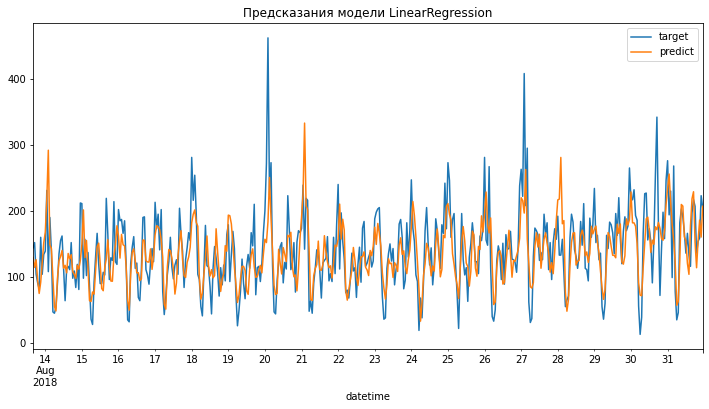

In [ ]:
LR = pd.DataFrame({"target":target_test, "predict":model_LR_test_predict})
LR.plot(figsize=(12, 6))
plt.title("Предсказания модели LinearRegression")

Text(0.5, 1.0, 'Предсказания модели RandomForestRegressor')

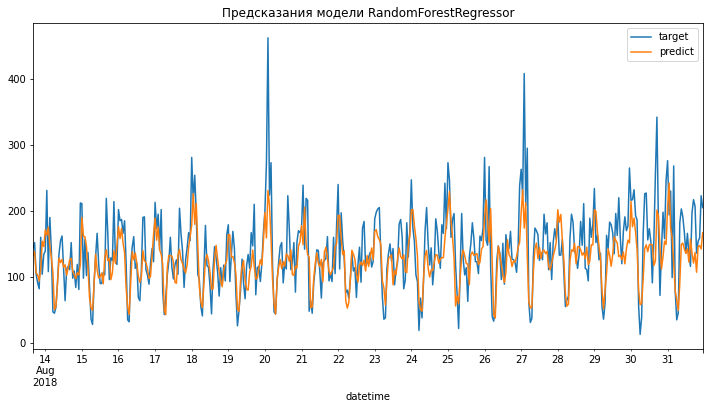

In [ ]:
RFR = pd.DataFrame({"target":target_test, "predict":model_RFR_test_predict})
RFR.plot(figsize=(12, 6))
plt.title("Предсказания модели RandomForestRegressor")

Text(0.5, 1.0, 'Предсказания модели CatBoostRegressor')

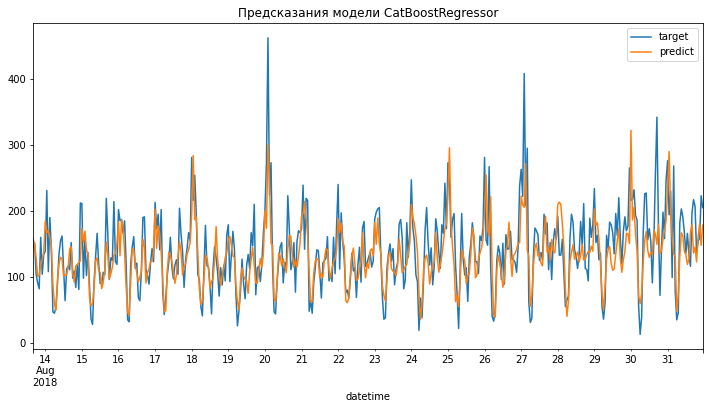

In [ ]:
CAT = pd.DataFrame({"target":target_test, "predict":model_CAT_test_predict})
CAT.plot(figsize=(12, 6))
plt.title("Предсказания модели CatBoostRegressor")

**Вывод**

В рамках выполнения проекта:
1. Произведена загрузка данных,их подготовка для обучения моделей.
- В данных представлена информация о заказах такси за 2018 год. 
- Данные представлены 26,5 тысяч строк.

2. Произведен анализ имеющихся данных:
- За исследуемый период наблюдается рост количества заказов.
- При построении графика сезонности наблюдается суточная сезонность: максимум заказов приходится на вечер, а ночью стремится к нулю.

3. Проведена подготовка данных к построению моделей, подбор гиперпараметров.
- Для успешного построения моделей исходные данные были дополнены новыми признаками день, день недели, час, "отстающие значения" и скользящее среднее.
- Обучены модели, подобраны опртимальные гиперпараметры.

4. Проведено тестирование моделей.
- Все модели достигли требуемого показателя метрики RMSE. 
- Сравнение графиков полученных предсказаний и исходных данных показал, что модели хуже всего справляются с предсказаниями на высоких пиках и на провалах.
- Наилучший показатель RMSE в данном случае у CatBoostRegressor.

